# 机器学习纳米学位毕业项目 -- 猫狗大战
---

苗沛

2018.09.15

## I. 问题的定义
---

### 项目概述

本项目来源于 kaggle 竞赛项目， 最终目的是训练一个机器学习模型， 输入一张图片来分辨图像中的猫和狗，也可是猫或狗的面部坐标甚至是身体的一部分。是一个典型的图像二分类问题。

本项目使用的卷积神经网络(Convolutional Neural Network, CNN)，卷积神经网络是深度学习技术中极具代表的网络结构之一，在图像处理领域取得了很大的成功，在国际标准的ImageNet数据集上，许多成功的模型都是基于CNN的。CNN相较于传统的图像处理算法的优点之一在于，避免了对图像复杂的前期预处理过程（提取人工特征等），可以直接输入原始图像。CNN网络对图片进行多次卷基层和池化层处理，在输出层给出两个节点并进行softmax计算得到两个类别各自的概率。

本项目最终需要训练基于 CNN 的机器学习模型，对测试样本进行分类，并将最终结果上传 kaggle 进行最终评判。

本项目同时也实现了使用 Keras 和 Flask 搭建部署一个简单易用的深度学习图像网页应用，可以通过网页导入一张彩色猫或者狗的图片预测是猫或者狗的概率。

### 问题称述

- 数据集中大部分图片是正常的，有少部分异常图片和低分辨率图片，对于训练集来说这些异常数据是要剔除掉的。

- 数据集中的文件名是以type.num.jpg方式命名的，比如cat.0.jpg。使用 Keras 的 ImageDataGenerator 需要将不同种类的图片分在不同的文件夹中。

- 数据集中的图像大小是不固定的，但是神经网络输入节点的个数是固定的。所以在将图像的像素作为输入之前，需要将图像的大小进行resize。

### 评价指标

对数损失（Log loss）亦被称为逻辑回归损失（Logistic regression loss）或交叉熵损失（Cross-entropy loss）。 交叉熵是常用的评价方式之一，它实际上刻画的是两个概率分布之间的距离，是分类问题中使用广泛的一种损失函数。

本文实际上是二分类问题， 因此可以采用 logloss 损失函数作为评价指标， 计算公式如下：

$$ LogLoss = -\frac{1}{n}\sum_{i=1}^n [y_ilog(\hat{y}_i)+(1-y_i)log(1- \hat{y}_i)]$$

其中：

- n 是测试集中图片数量
- $\hat{y}_i$ 是图片预测为狗的概率
- $y_i$ 如果图像是狗，则为1，如果是猫，则为0
- $log()$ 是自然（基数 $e$）对数

采用交叉熵作为损失函数可以有效的解决梯度消失和梯度爆炸的问题。

交叉熵损失越小，代表模型的性能越好。上述评估指标可用于评估该项目的解决方案以及基准模型。

## II. 分析
---

### 数据的探索

下载kaggle猫狗数据集解压后分为 3 个文件 train.zip、 test.zip 和 sample_submission.csv。

train 训练集包含了 25000 张猫狗的图片， 每张图片包含图片本身和图片名。命名规则根据“type.num.jpg”方式命名。

test 测试集包含了 12500 张猫狗的图片， 每张图片命名规则根据“num.jpg”，需要注意的是测试集编号从 1 开始， 而训练集的编号从 0 开始。

sample_submission.csv 需要将最终测试集的测试结果写入.csv 文件中，上传至 kaggle 进行打分。

从训练集中随机提取图片可视化如下：

<img src="source/train_range_img.png">

训练集中图片的尺寸散点分布图:

<img src="source/train_scatter_diagram.png">

测试集中图片的尺寸散点分布图：

<img src="source/test_scatter_diagram.png">

经过筛选训练集中异常图片和低像素图片可视化：

<img src="source/train_low_resolution_pictures.png">

从以上可视化分析得出：数据集中大部分图片是正常的，有少部分异常图片和低分辨率图片，对于训练集来说这些异常数据是要剔除掉的。去除异常数据后数据分布如下：

<img src="source/new_data_distribution.png">

数据集清洗后，猫的数量：12479，狗的数量：12476，测试集图片数量：12500

由于训练集混合了猫狗的图片，因此我们首先需要对图片进行分类， 分为 cat 和
dog 两个文件夹。

文件目录结构如下：

```python
image/
├── test 
├── img_test
│   ├── test -> ../test/
├── train 
├── img_train
│   ├── cat 
│   └── dog 
```

### 算法和技术

#### 问题分析及模型选择

在给定一张图片，系统需要预测出图像属于预先定义类别中的哪一类。在计算机视觉领域，目前解决这类问题的核心技术框架是深度学习（Deep Learning），特别地，针对图像类型的数据，是深度学习中的卷积神经网络（Convolutional Neural Networks, ConvNets）架构。常见的卷积神经网络架构如下：

<img src="source/CNNs_framwork.png">

卷积神经网络中卷积层和池化层主要是对图片的几何特征进行抽取，比如浅层的卷积池化层可以抽取出一些直线，角点等简单的抽象信息，深层的卷积池化层可以抽取人脸等复杂的抽象信息，最后的全连接层才是对图片分类的关键处理。因此可以利用已经训练好的卷积神经网络提取图片中复杂的几何特征，即将原始图片用已经训练好的卷积神经网络处理之后的输出，作为新的输入，然后加上自己的全连接层，去进行分类。在模型训练的过程中，只改变新加的全连接层的权重。

由于每一种神经网络提取的特征都不一样，因此本项目将多个神经网络处理的结果拼接，作为最后一层全连接层的输入，这样做可以有效地降低方差。

总的来说，卷积神经网络是一种特殊的神经网络结构，即通过卷积操作可以实现对图像特征的自动学习，选取那些有用的视觉特征以最大化图像分类的准确率。

<img src="source/cat_dog_classify.gif"/>

上图给出了一个简单的猫狗识别的卷积神经网络结构，在最底下（同时也是最大的）的点块表示的是网络的输入层（Input Layer），通常这一层作用是读入图像作为网络的数据输入。在最上面的点块是网络的输出层（Output Layer），其作用是预测并输出读入图像的类别，在这里由于只需要区分猫和狗，因此输出层只有2个神经计算单元。而位于输入和输出层的，都称之为隐含层（Hidden Layer），图中有3个隐含层，图像分类的隐含层都是由卷积操作完成的，因此这样的隐含层也成为卷积层（Convolutional Layer）。因此，输入层、卷积层、输出层的结构及其对应的参数就构成了一个典型的卷积神经网络。当然，在实际中使用的卷积神经网络要比这个示例的结构更加复杂，自2012年的ImageNet比赛起，几乎每一年都会有新的网络结构诞生，已经被大家认可的常见网络有AlexNet, VGG-Net, GoogLeNet, Inception V2-V4, ResNet等等。这些卷积神经网络都是在ImageNet数据集上表现非常优异的神经网络，具体准确率和模型大小如下图所示。

<img src="source/nnarch1-1.png"/>

<img src="source/imagenet_info.png">

本项目迁移学习部分使用Keras实现，而Keras中可以导入的模型有Xception，VGG16，VGG19，ResNet50，InceptionV3，InceptionResNet -V2，MobileNet. 综合考虑模型的分类准确率和大小，选用迁移学习的基础模型为ResNet50，InceptionV3和Xception。

#### 算法

https://www.jiqizhixin.com/articles/2017-08-19-4

https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/

https://zhuanlan.zhihu.com/p/33528315

https://my.oschina.net/u/876354/blog/1620906

https://zhuanlan.zhihu.com/p/38681805

https://cloud.tencent.com/developer/article/1087163

https://www.cnblogs.com/pinard/p/6483207.html

**ResNet50：**



Xception

Inception V3

#### 技术


### 基准模型

基准模型选择ResNet50, Xception, Inception V3 这三个模型完成。

ResNet50

Xception

Inception V3

本项目的最低要求是 kaggle Public Leaderboard 前10%。在kaggle上，总共有1314只队伍参加了比赛，所以需要最终的结果排在131位之前，131位的得分是0.06127，所以目标是模型预测结果要小于0.06127。

## III. 方法
---


### 数据预处理


### 执行过程


### 完善


## IV. 结果
---

### 模型的评价与验证


### 合理性分析



## V. 项目结论
---


### 结果可视化


### 对项目的思考


### 需要作出的改进




In [1]:
%pwd

'/home/miaopei/workdir/github/DeepLearning/cat_vs_dog'

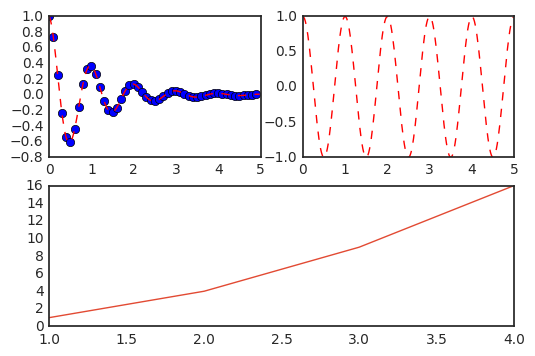

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

plt.style.use('seaborn-white')
# plt.style.use('ggplot')
# plt.plot([1, 2, 3, 4], [1, 4, 9, 16], 'ro')
# plt.axis([0, 6, 0, 20])
# plt.show()

# t = np.arange(0., 5., 0.2)
# plt.plot(t, t, 'r--', t, t ** 2, 'bs', t, t ** 3, 'g^')
 
def f(t):
    return np.exp(-t) * np.cos(2 * np.pi * t)

t1 = np.arange(0, 5, 0.1)
t2 = np.arange(0, 5, 0.02)

plt.figure(12)
plt.subplot(221)
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'r--')

plt.subplot(222)
plt.plot(t2, np.cos(2 * np.pi * t2), 'r--')

plt.subplot(212)
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])

In [12]:
from math import ceil
ceil(5/4)

2

In [ ]:
x = lamba row: int(row/4) + 